# Lecture 3 Linear Regression Coding Competition: Feature Engineering

In [3]:
import pandas as pd
import yfinance as yf
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns
from sklearn import linear_model
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore", category=Warning)

In [9]:
df = pd.read_csv("INFO6105_Final_TSLA_FeatureMart.csv")
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1187 entries, 0 to 1186
Data columns (total 54 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             1187 non-null   object 
 1   close            1187 non-null   float64
 2   high             1187 non-null   float64
 3   low              1187 non-null   float64
 4   open             1187 non-null   float64
 5   volume           1187 non-null   int64  
 6   SMA_10           1187 non-null   float64
 7   RSI_15           1187 non-null   float64
 8   MACD_5_20_9      1187 non-null   float64
 9   MACDh_5_20_9     1187 non-null   float64
 10  MACDs_5_20_9     1187 non-null   float64
 11  BBL_10_2.0       1187 non-null   float64
 12  BBM_10_2.0       1187 non-null   float64
 13  BBU_10_2.0       1187 non-null   float64
 14  BBB_10_2.0       1187 non-null   float64
 15  BBP_10_2.0       1187 non-null   float64
 16  OBV              1187 non-null   float64
 17  CDL_INSIDE    

In [11]:
# Features 
# X is your feature DataFrame
# load feature data
start_date = datetime(2020,1,1)
end_date = datetime(2024,12,31)
data_raw = pd.read_csv('INFO6105_FeatureMart.csv', index_col = [0])
data_raw.describe()
data_raw['Date'] = pd.to_datetime(data_raw['Date']) # set index to date
X_raw = data_raw.set_index('Date').fillna(method='bfill') # time-series data, preferrably using back-fill
X = pd.DataFrame(index = X_raw.index)

# preprocess data using min-max scaler
for column in X_raw.columns: 
     X[column] = (X_raw[column] - X_raw[column].min()) \
         / (X_raw[column].max() - X_raw[column].min())    

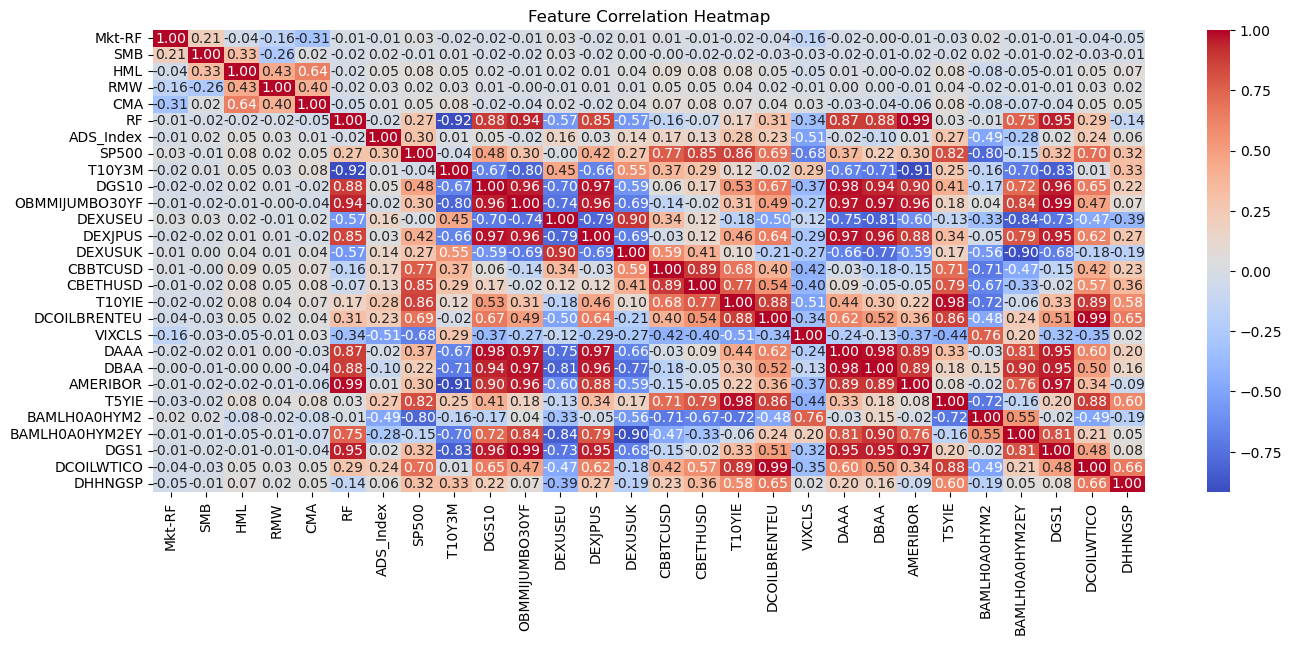

In [4]:
# Feature Heatmap
# Compute feature correlation heatmap
plt.figure(figsize=(16, 6))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()

In [5]:
# Target variable:
# y is your target DataFrame
# Download stock data
stock_symbol = 'TSLA'
stocks = yf.download(stock_symbol, start_date, end_date)
stock = stocks.xs(stock_symbol, axis = 1, level = 'Ticker')
price_type = 'Close'


# target 1: price_type
y = stock[price_type]
'''
# target 2: price_type log_return
# Compute log daily returns
y_log_return = np.log(y / y.shift(1))
# The first-day value will be NaN, replace it with the second-day value
y_log_return = y_log_return.fillna(method='bfill')
# Rename column for clarity
y_log_return.columns = [f'{price_type} log_return']
y = y_log_return
'''

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


"\n# target 2: price_type log_return\n# Compute log daily returns\ny_log_return = np.log(y / y.shift(1))\n# The first-day value will be NaN, replace it with the second-day value\ny_log_return = y_log_return.fillna(method='bfill')\n# Rename column for clarity\ny_log_return.columns = [f'{price_type} log_return']\ny = y_log_return\n"

#### Game 1: correlation with target

In [7]:
# Compute correlation between features and target
feature_target_correlation = X.corrwith(y.squeeze())
# print("Feature Correlation with Target:")
# print(feature_target_correlation)

# Sort features by their correlation with target
sorted_correlation = feature_target_correlation.abs().sort_values(ascending=False)

# Print mean sorted correlation
print("Feature Mean Correlation with Target (Sorted):")
print(sorted_correlation.mean())

# Print max and min correlation
print("\n Max Correlation:")
print(sorted_correlation.idxmax(), sorted_correlation.max())
print("\n Min Correlation:")
print(sorted_correlation.idxmin(), sorted_correlation.min())

Feature Mean Correlation with Target (Sorted):
0.4024879423403926

 Max Correlation:
SP500 0.9132500180388884

 Min Correlation:
CMA 0.0077809835490284035


In [8]:
'''
# if you have many features that are categorical 0-1 alone
# use the following correlation calculation
from scipy.stats import pointbiserialr

binary_vector = X_binary
continuous_vector = y 

# Assuming `binary_vector` is your categorical (0-1) vector and `continuous_vector` is your numerical vector
correlation, p_value = pointbiserialr(binary_vector, continuous_vector)
print(f"Point-Biserial Correlation: {correlation}")
print(f"P-value: {p_value}")

# To calculate the correlation between a categorical vector with 0-1 values and a continuous numerical vector, 
# you can use Point-Biserial Correlation, which is a special case of the Pearson correlation.
'''

'\n# if you have many features that are categorical 0-1 alone\n# use the following correlation calculation\nfrom scipy.stats import pointbiserialr\n\nbinary_vector = X_binary\ncontinuous_vector = y \n\n# Assuming `binary_vector` is your categorical (0-1) vector and `continuous_vector` is your numerical vector\ncorrelation, p_value = pointbiserialr(binary_vector, continuous_vector)\nprint(f"Point-Biserial Correlation: {correlation}")\nprint(f"P-value: {p_value}")\n\n# To calculate the correlation between a categorical vector with 0-1 values and a continuous numerical vector, \n# you can use Point-Biserial Correlation, which is a special case of the Pearson correlation.\n'

#### Game 2: ordinary linear regression

In [10]:
# Benchmark Model: Two-Step Factor Selection (Hard Thresholding Method)
# Motivation: the method selects features according to their significance in 
# an OLS regression for Y
# Step 1: regress Y on all features in X and remove those whose p-val > 0.05 (|t|<1.96)
# Step 2: regress Y on the subset of X
X = sm.add_constant(X)
benchmark_prep = sm.OLS(y,X).fit()
benchmark_prep.summary()
benchmark_select = X.columns[np.abs(benchmark_prep.tvalues)>=1.96]
x = X[benchmark_select]
benchmark = sm.OLS(y,x).fit()
print(benchmark.summary())
y_hat_benchmark1 = benchmark.predict(x)
corr_benchmark1 = ss.pearsonr(y_hat_benchmark1, y)[0]
print('benchmark: corr (Y, Y_pred) = '+str(corr_benchmark1))
print('hard-thresholding (p <= 0.05) selected ' +str(len(benchmark_select)) +' features: ', benchmark_select.values)

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     1791.
Date:                Tue, 18 Mar 2025   Prob (F-statistic):               0.00
Time:                        12:48:53   Log-Likelihood:                -3722.2
No. Observations:                1006   AIC:                             7480.
Df Residuals:                     988   BIC:                             7569.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             87.7813     12.149      7.